<h1 align="center"> Лабораторная работа №6 </h1>

---

<h1 align="center"> Университет ИТМО </h1>
<h2 align="center"> Факультет систем управления и робототехники </h2>

---

### Выполнили:
- **Соколов Никита**  
- **Минеев Кирилл**
- **Соловьев Дмитрий**
- **Семёнов Евгений**

---

### Проверил:
- **Догадин Егор Витальевич**

---

### 29 ноября 2024 г.

---

# Подготовка.

### Установка необходимых библиотек:

In [20]:
%pip install matplotlib numpy opencv-python natasha nltk pandas sympy wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sympy import Matrix, latex
from IPython.display import display, HTML, Math
import nltk
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import cv2 as cv
from natasha import MorphVocab, Doc, Segmenter, NewsEmbedding, NewsMorphTagger
import re

# **Задание 1. Сжатие изображений.** Одно из самых наглядных применений сингулярного разложения.

### 1.1 Изображение, преобразованное его к оттенкам серого и представленное в виде матрицы.


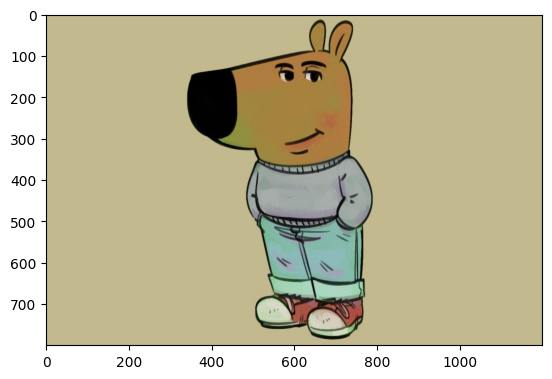

In [22]:
image = cv.imread('assets/chill-guy.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.imshow(image)

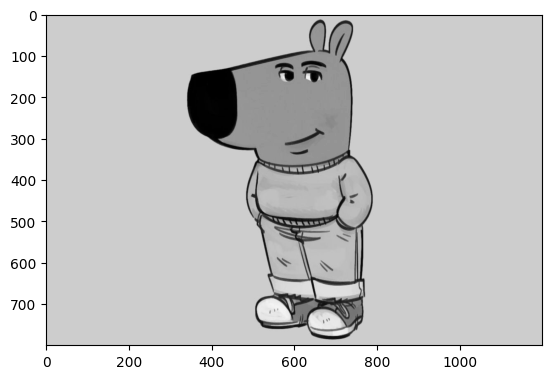

In [23]:
# grayscale
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

plt.imshow(image, cmap='gray')

### 1.2 $SVD$-разложение получившейся матрицы

In [24]:
u, s, v_t = np.linalg.svd(image)

In [25]:
singular_matrix = np.zeros((image.shape[0], image.shape[1]))
singular_matrix[:image.shape[0], :image.shape[0]] = np.diag(s)

### 1.3 Укороченное $SVD$ разложение этой матрицы, в которой только $k$ первых (наибольших) сингулярных чисел и соответствующих им векторов. Вывод полученных изображений.

k = 100, compression rate = 20.84%


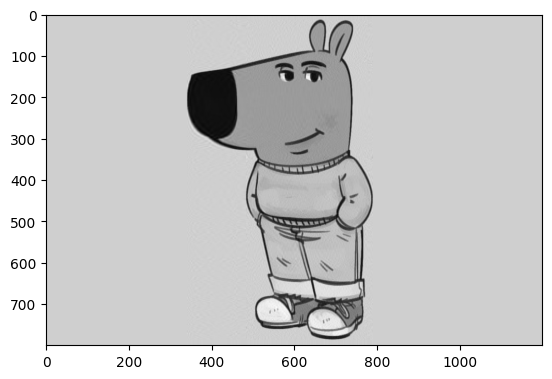

k = 70, compression rate = 14.59%


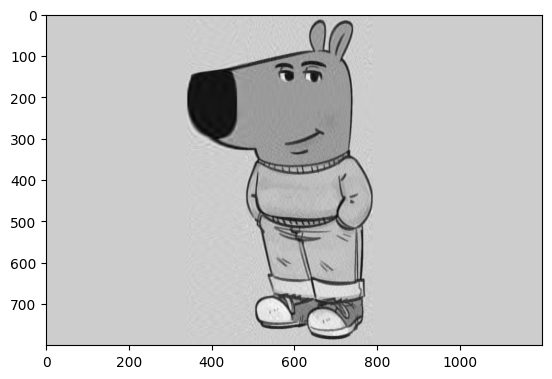

k = 60, compression rate = 12.51%


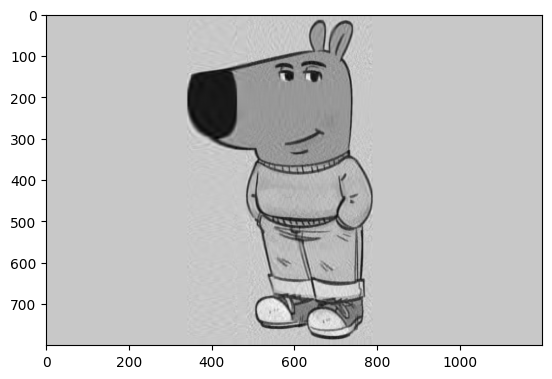

k = 50, compression rate = 10.42%


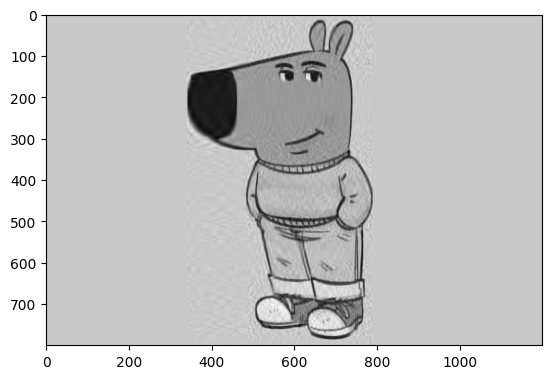

k = 30, compression rate = 6.25%


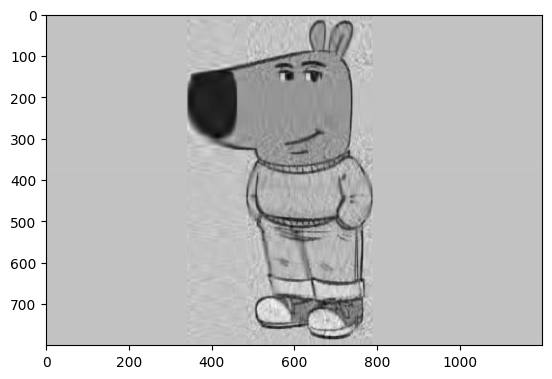

k = 20, compression rate = 4.17%


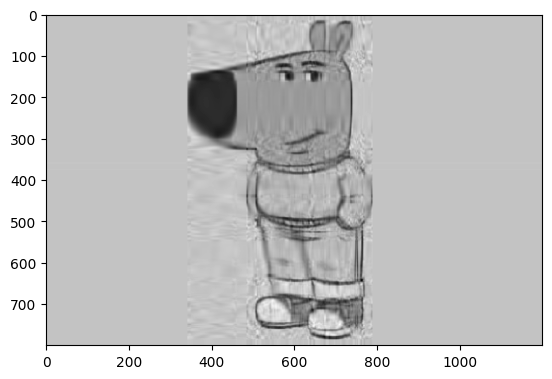

k = 15, compression rate = 3.13%


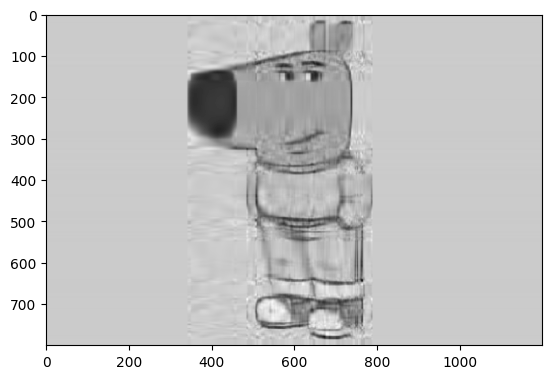

k = 10, compression rate = 2.08%


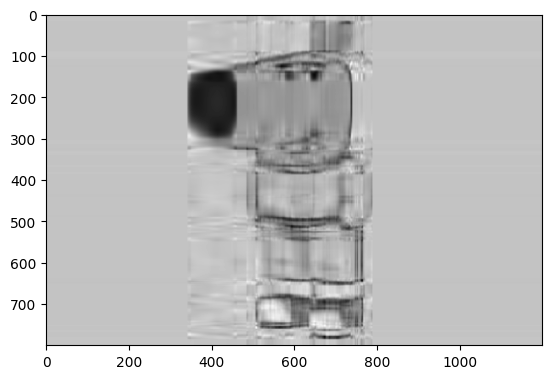

k = 1, compression rate = 0.21%


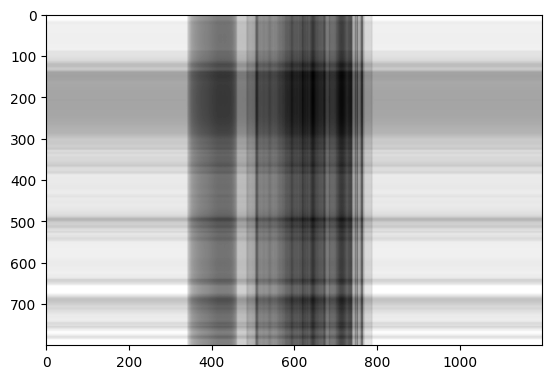

In [26]:
m, n = image.shape
original_size = m * n

for k in (100, 70, 60, 50, 30, 20, 15, 10, 1):
    img_r = u[:, :k] @ singular_matrix[:k, :k] @ v_t[:k, :]
    compressedSize = k * (1 + m + n)
    ratio = compressedSize / original_size
    print(f'k = {k}, compression rate = {round(ratio * 100, 2)}%')
    
    plt.imshow(img_r, cmap='gray')
    plt.show()

### 1.4 Выводы о влиянии параметра $k$ на качество вашего изображения и степень сжатия (какую долю от исходной информации необходимо хранить в памяти). При каких значениях $k$ картинка имеет приемлемое качество? При каких значениях качество уже не очень, но картинка всё ещё различима? Для каких $k$ картинка становится совершенно непонятной? Оценка численной степени сжатия изображения при каждом из рассмотренных вами значений параметра $k$.

Изменяя параметр $k$, мы можем исключить меньшие по значению сингулярные числа, существенно сократив объем хранимой информации, при этом сохранив качество изображения на приемлемом уровне. Как показывает пример, при сжатии до $10\%$ изображение остается достаточно четким и узнаваемым. Однако при дальнейшем уменьшении, начиная с уровня сжатия около $6\%$ и ниже, четкость изображения значительно ухудшается, и картинка становится трудноразличимой.

# Задание 2. Latent Semantic Analysis. 

In [27]:
def read_file(path):
    with open(path, encoding="utf-8") as file:
        return file.read()
    

In [28]:
def lemmatize_text(cleaned_words):
    segmenter = Segmenter()
    embeddings = NewsEmbedding()
    morph_tagger = NewsMorphTagger(embeddings)
    morph_vocab = MorphVocab()

    lemmatized_sentences = []
    for cleaned_sentence in cleaned_words:
        doc = Doc(' '.join(cleaned_sentence))
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        for token in doc.tokens:
            token.lemmatize(morph_vocab)
        lemmatized_sentences.append([token.lemma for token in doc.tokens if token.lemma])
    return lemmatized_sentences

### 2.1 Удаление знаков препинания и разделение текста на отдельные слова.

In [29]:
text_list = eval(read_file("data/data5.txt"))

cleaned_words = [
    re.findall(r'\b\w+\b', sentence) for sentence in text_list
]

### 2.2 Лемматизация текста

In [30]:
lemmatized_text = lemmatize_text(cleaned_words)

### 2.3 Исключение "шумовых" слов.

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
def remove_noise_words(texts):
    stop_words = set(stopwords.words('russian'))
    return [[word for word in text if word not in stop_words] for text in texts]

In [33]:
filtered_text = remove_noise_words(lemmatized_text)

### 2.4 Терм-документная матрица

In [34]:
def get_term_document_matrix(filtered_texts):
    all_words = [word for text in filtered_texts for word in text]
    word_counts = Counter(all_words)

    term_document_matrix = []
    for text in filtered_texts:
        term_counts = Counter(text)
        term_document_matrix.append([term_counts.get(word, 0) for word in word_counts.keys()])

    return np.array(term_document_matrix), word_counts

In [35]:
term_document_array, word_count = get_term_document_matrix(filtered_text)
columns = list(word_count.keys())

term_matrix_df = pd.DataFrame(term_document_array, columns=columns)

display(HTML("<h3>Терм-документная матрица:</h3>"))
display(HTML(term_matrix_df.to_html(index=False)))

приготовление,салат,цезарь,понадобиться,лист,куриный,филе,гренка,соус,чизкейк,приготовить,выпечка,использовать,творог,сливка,желатин,свежий,овощ,украшаться,зелень,заправляться,оливковый,масло,вкусный,кофе,нужный,зерно,правильно,смолоть,торт,получаться,песочный,тест,добавление,шоколад,сливочный,крем,запекание,мясо,следовать,посолить,поперчить,обмариновать,специя,составление,бюджет,необходимый,учитывать,весь,доход,расход,инвестирование,акция,мочь,принести,высокий,прибыль,сопрячь,риск,финансовый,грамотность,позволять,принимать,взвесить,решение,достигать,цель,кредит,брать,случай,крайний,необходимость,наличие,возможность,погашение,фруктовый,любой,яблоко,банан,клубника,налоговый,декларация,указывать,планирование,помогать,избежать,долг,обеспечить,комфортный,жизнь,сбережение,хранить,депозит,приносить,процент,хлеб,требоваться,мука,вода,дрожжи,немного,соль,диверсификация,портфель,снижать,повышать,стабильность,суп,нарезать,обжарить,сковорода,подача,горячий,блюдо,полить,украсить,творожный,пирог,нежный,добавить,сметана,тесто,макароны,просто,варить,подсолить,готовность
1,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2.5 $SVD$-Разложение матрицы

In [36]:
u, s, v_t = np.linalg.svd(term_document_array, full_matrices=False)

In [37]:
u_df = pd.DataFrame(u)
vt_df = pd.DataFrame(v_t, columns=columns)

display(HTML("<h3>Левая сингулярная матрица:</h3>"))
display(HTML(u_df.to_html(index=False)))

display(HTML("<h3>Сингулярные значения:</h3>"))
display(Math(f"\\begin{{bmatrix}} {latex(Matrix(s))} \\end{{bmatrix}}"))

display(HTML("<h3>Правая сингулярная матрица:</h3>"))
display(HTML(vt_df.to_html(index=False)))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-6.658203e-01,-1.234732e-15,4.311185e-18,4.938374e-01,-1.597011e-01,-2.041208e-01,1.450647e-01,-2.477838e-16,3.712253e-01,-4.813020e-02,1.825620e-01,2.684171e-16,1.539058e-01,4.519232e-02,-1.078989e-16,1.323887e-02,4.944643e-02,-3.324528e-28,1.509680e-01,-2.824288e-18
-1.537743e-01,5.154275e-15,9.602696e-17,-3.806072e-01,3.797016e-02,1.417399e-01,2.079046e-01,7.036522e-16,1.489748e-01,-1.384525e-01,1.706430e-01,9.840742e-17,1.956866e-01,2.477359e-01,1.247758e-15,2.941769e-01,-7.090794e-01,2.565378e-26,-8.516875e-02,-2.374529e-17
-4.063032e-01,2.446660e-15,-4.499374e-17,5.430521e-02,5.857109e-03,6.552047e-02,-1.330369e-01,6.367840e-16,-5.279187e-01,1.513717e-01,-2.545767e-01,-5.614582e-16,-3.987792e-01,-6.718263e-02,1.553189e-15,1.444364e-01,-2.920471e-01,2.388860e-27,4.169292e-01,2.759964e-17
-3.203121e-01,-2.750567e-15,-1.067451e-16,-5.771640e-01,4.518860e-02,1.525372e-01,-2.737387e-01,1.811582e-16,-5.025248e-03,7.716824e-02,1.983969e-01,3.199682e-16,2.602551e-01,1.454578e-01,-5.990476e-16,6.038935e-02,4.727458e-01,-1.489780e-26,3.204243e-01,4.984084e-17
-5.540300e-02,-2.052170e-15,-3.496078e-16,-2.479788e-01,1.199124e-01,-7.005567e-01,-4.383243e-01,1.127744e-16,1.998865e-01,-2.361355e-01,6.897777e-02,-2.362066e-16,-3.282524e-01,-9.214350e-02,6.255211e-16,4.972806e-02,-1.035579e-01,2.610914e-26,-9.077695e-02,-3.051788e-17
-2.376641e-02,6.224937e-16,8.826773e-17,5.497616e-02,3.891641e-01,5.105162e-02,-2.547674e-03,-6.449504e-16,-8.038172e-02,-2.088524e-01,8.643138e-02,7.876821e-16,3.576431e-01,-7.790920e-01,7.184803e-15,1.956947e-01,-5.294711e-02,8.389601e-26,9.384894e-02,-1.449914e-16
-5.878221e-18,6.515279e-01,-7.812550e-16,-1.399168e-17,3.371915e-18,-2.411408e-15,-1.806363e-16,1.003858e-01,4.160868e-16,-1.131607e-16,-1.737165e-16,2.281540e-15,1.787228e-16,-9.937029e-16,-1.160677e-01,9.543384e-16,4.274252e-15,5.147387e-17,8.344648e-18,7.429417e-01
-5.612135e-19,4.949618e-02,3.557478e-16,-4.809233e-18,-3.075403e-16,1.366587e-17,-6.470216e-16,-8.832041e-01,-6.024419e-16,-1.255354e-16,6.180213e-16,-2.272694e-14,1.573458e-16,-2.360092e-15,-4.663596e-01,4.214200e-15,-7.888159e-16,-3.086118e-16,1.951661e-16,3.073797e-03
-2.249639e-19,-5.420415e-16,-8.944272e-01,6.513468e-18,-5.569286e-17,3.654630e-17,9.280555e-17,1.129039e-14,-1.796998e-17,-3.551037e-17,3.641286e-16,-4.472136e-01,4.799870e-16,-4.253855e-16,-1.810565e-16,-3.311437e-16,-5.844529e-17,1.920811e-17,-1.158487e-17,-4.040967e-16
-3.052957e-02,4.889865e-16,-1.500872e-16,8.385519e-02,7.543304e-01,1.151168e-01,-7.306073e-03,-4.925000e-16,3.883845e-01,4.355670e-01,-1.342438e-01,-3.113980e-16,-1.694594e-01,1.452231e-01,-9.296574e-16,-5.705860e-03,-1.519744e-02,-5.309689e-26,3.262478e-02,1.128692e-16


<IPython.core.display.Math object>

приготовление,салат,цезарь,понадобиться,лист,куриный,филе,гренка,соус,чизкейк,приготовить,выпечка,использовать,творог,сливка,желатин,свежий,овощ,украшаться,зелень,заправляться,оливковый,масло,вкусный,кофе,нужный,зерно,правильно,смолоть,торт,получаться,песочный,тест,добавление,шоколад,сливочный,крем,запекание,мясо,следовать,посолить,поперчить,обмариновать,специя,составление,бюджет,необходимый,учитывать,весь,доход,расход,инвестирование,акция,мочь,принести,высокий,прибыль,сопрячь,риск,финансовый,грамотность,позволять,принимать,взвесить,решение,достигать,цель,кредит,брать,случай,крайний,необходимость,наличие,возможность,погашение,фруктовый,любой,яблоко,банан,клубника,налоговый,декларация,указывать,планирование,помогать,избежать,долг,обеспечить,комфортный,жизнь,сбережение,хранить,депозит,приносить,процент,хлеб,требоваться,мука,вода,дрожжи,немного,соль,диверсификация,портфель,снижать,повышать,стабильность,суп,нарезать,обжарить,сковорода,подача,горячий,блюдо,полить,украсить,творожный,пирог,нежный,добавить,сметана,тесто,макароны,просто,варить,подсолить,готовность
-2.164936e-01,-5.605134e-01,-1.717527e-01,-1.717527e-01,-1.717527e-01,-1.717527e-01,-1.717527e-01,-1.717527e-01,-2.130959e-01,-3.966711e-02,-2.650081e-01,-5.015456e-02,-1.222937e-01,-3.966711e-02,-3.966711e-02,-3.966711e-02,-2.996346e-01,-1.495495e-01,-1.048086e-01,-1.461517e-01,-1.048086e-01,-1.048086e-01,-1.048086e-01,-9.691819e-02,-8.262662e-02,-1.273675e-01,-8.262662e-02,-8.262662e-02,-8.262662e-02,-1.429157e-02,-1.781723e-02,-1.429157e-02,-1.429157e-02,-1.429157e-02,-1.429157e-02,-1.429157e-02,-1.429157e-02,-6.130702e-03,-6.130702e-03,-5.534914e-02,-6.130702e-03,-6.130702e-03,-6.130702e-03,-6.130702e-03,-5.745194e-18,-3.192349e-18,-5.745194e-18,-3.192349e-18,-5.745194e-18,-7.619312e-18,-5.745194e-18,-2.611019e-18,-2.611019e-18,-2.611019e-18,-2.611019e-18,-2.611019e-18,-2.611019e-18,-2.611019e-18,-2.914910e-18,5.944896e-19,-1.149576e-18,-1.149576e-18,-1.149576e-18,-1.149576e-18,-1.149576e-18,-1.149576e-18,-1.149576e-18,-7.875306e-03,-7.875306e-03,-7.875306e-03,-7.875306e-03,-7.875306e-03,-7.875306e-03,-7.875306e-03,-7.875306e-03,-1.121993e-01,-1.121993e-01,-1.121993e-01,-1.121993e-01,-1.121993e-01,-2.742822e-18,-2.742822e-18,-2.742822e-18,-6.489831e-19,-6.489831e-19,-6.489831e-19,-6.489831e-19,-6.489831e-19,-6.489831e-19,-6.489831e-19,2.081169e-19,2.081169e-19,2.081169e-19,2.081169e-19,2.081169e-19,-1.048745e-02,-1.048745e-02,-1.048745e-02,-4.100249e-02,-1.048745e-02,-1.401312e-02,-1.048745e-02,-7.972402e-19,-7.972402e-19,-7.972402e-19,-7.972402e-19,-7.972402e-19,-4.474085e-02,-4.474085e-02,-4.474085e-02,-4.474085e-02,-4.134313e-02,-4.134313e-02,-4.134313e-02,-4.134313e-02,-4.134313e-02,-3.525662e-03,-3.525662e-03,-3.525662e-03,-3.525662e-03,-3.525662e-03,-3.525662e-03,-3.051504e-02,-3.051504e-02,-3.051504e-02,-3.051504e-02,-3.051504e-02
8.047049e-17,-1.093644e-17,-5.568316e-16,-5.585003e-16,-5.589368e-16,-5.589943e-16,-6.074949e-16,-5.638397e-16,-9.652724e-16,3.393340e-15,1.711530e-15,1.713876e-15,1.393393e-15,3.393340e-15,3.394148e-15,3.393288e-15,-8.921387e-16,2.127255e-15,1.499471e-15,1.093193e-15,1.499471e-15,1.499471e-15,1.499471e-15,-2.533754e-15,-1.999946e-15,-1.372162e-15,-1.999946e-15,-1.999946e-15,-1.999946e-15,-5.338070e-16,-7.824600e-16,-5.338070e-16,-5.338070e-16,-5.338070e-16,-5.338070e-16,-5.338070e-16,-5.338070e-16,3.310219e-16,3.310219e-16,1.115007e-16,3.310219e-16,3.310219e-16,3.310219e-16,3.310219e-16,3.815116e-01,1.815643e-01,3.815116e-01,1.815643e-01,3.815116e-01,4.487778e-01,3.815116e-01,1.379333e-02,1.379333e-02,1.379333e-02,1.379333e-02,1.379333e-02,1.379333e-02,1.379333e-02,8.105955e-02,-3.859132e-16,-1.385107e-16,-1.385107e-16,-1.385107e-16,-1.385107e-16,-1.385107e-16,-1.385107e-16,-1.385107e-16,1.867569e-16,1.867569e-16,1.867569e-16,1.867569e-16,1.867569e-16,1.867569e-16,1.867569e-16,1.867569e-16,-3.916630e-16,-3.916630e-16,-3.916630e-16,-3.916630e-16,-3.916630e-16,1.999473e-01,1.999473e-01,1.999473e-01,-1.088917e-16,-1.088917e-16,-1.088917e-16

###  2.6 Какой смысл имеют столбцы/строки матриц $U$ и $V$ ? Какой смысл имеют сингулярные числа матрицы $\Sigma$?

#### 1. Матрица $ U $ (левая сингулярная матрица):
- **Строки $ U $:** Представляют термины в новом пространстве признаков (латентном семантическом пространстве). Каждый термин проецируется в это пространство как вектор, который описывает его значение относительно латентных семантических факторов (скрытых тем).
- **Столбцы $ U $:** Соответствуют **латентным темам** (компонентам), обнаруженным в терм-документной матрице. Они показывают, насколько каждый термин связан с определённой латентной темой.
- **Смысл:** 
  - $ U $ помогает понять, какие термины важны для каждой из тем.
  - Например, в задаче анализа текстов термины, связанные с одной темой, будут иметь схожие координаты в соответствующем столбце матрицы $ U $.

---

#### 2. Сингулярные числа ($ \Sigma $):
- **Элементы диагональной матрицы $ \Sigma $:** Показывают относительный вклад каждой латентной темы в общее содержание терм-документной матрицы.
- **Смысл:** 
  - Они сортируются по убыванию, и первые несколько сингулярных чисел обычно содержат основную часть информации.
  - Чем больше значение сингулярного числа, тем более значимая тема, связанная с этим числом.
  - Меньшие значения сингулярных чисел соответствуют менее значимым (или шумовым) темам.

---

#### 3. Матрица $ V^T $ (правая сингулярная матрица):
- **Строки $ V^T $:** Представляют документы в латентном семантическом пространстве. Каждый документ проецируется как вектор, который показывает его принадлежность к латентным темам.
- **Столбцы $ V^T $:** Соответствуют латентным темам. Они показывают, насколько каждый документ связан с конкретной латентной темой.
- **Смысл:** 
  - $ V^T $ помогает понять, какие документы близки друг к другу по темам.
  - Например, если два документа имеют похожие координаты в латентном пространстве, они, вероятно, обсуждают схожие темы.

---

#### Интерпретация в контексте LSA:
- **Матрица $ U $:** Помогает понять, какие термины составляют основные темы.
- **Матрица $ V^T $:** Помогает выявить тематическую близость между документами.
- **Сингулярные числа ($ \Sigma $):** Показывают, насколько значима каждая тема. Большие числа указывают на темы, которые имеют большое влияние на общую структуру данных.

---

#### Пример:
Если у вас есть текстовый корпус, сингулярное разложение выделяет скрытые паттерны:
1. **Термины** (строки $ U $) группируются по схожим темам.
2. **Документы** (строки $ V^T $) группируются по обсуждаемым темам.
3. Удалив меньшие сингулярные числа, можно избавиться от шума и оставить только значимые темы.

---

#### Практическая польза:
LSA позволяет обобщать данные:
- Схожие термины и документы объединяются в группы, даже если они не имеют прямых совпадений.
- Позволяет справляться с проблемой синонимов и многозначности в текстах.


### 2.7 Анализ первых двух сингулярных числа и соответствующих им правых и левых сингулярных векторов. Используя топ-5 слов с наибольшим отклонением в соответствующих векторах, восстановите основные две темы в тексте. Определите, каким документам эти темы соответствуют в наибольшей степени. В дополнение создайте диаграмму «облако слов» из словаря, где размер слова будет отражать его значимость для темы.

In [38]:
def create_wordcloud(topic_words, topic_values, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
        {word: abs(value) for word, value in zip(topic_words, topic_values)}
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()


def analyze_topics(u, v_t, s, words, documents):
    for i in range(2):
        topic_indices = np.argsort(np.abs(u[:, i]))[::-1][:5]
        topic_words = [words[j] for j in topic_indices]
        topic_values = u[topic_indices, i]
        
        print(f"\nТема {i + 1}:")
        print(pd.DataFrame({'Слово': topic_words, 'Значение': topic_values}))
        
        create_wordcloud(topic_words, topic_values, f"Облако слов для темы {i + 1}")
        
        if i < v_t.shape[0]:
            doc_indices = np.argsort(np.abs(v_t[i, :]))[::-1]
            doc_indices = [j for j in doc_indices if j < len(documents)]
            print(f"Документы для темы {i + 1}: {", ".join([documents[j] for j in doc_indices])}")
        else:
            print(f"Тема {i + 1}: отсутствует в V^T")


Тема 1:
           Слово  Значение
0  приготовление -0.665820
1    приготовить -0.434954
2         цезарь -0.406303
3   понадобиться -0.320312
4         свежий -0.173443


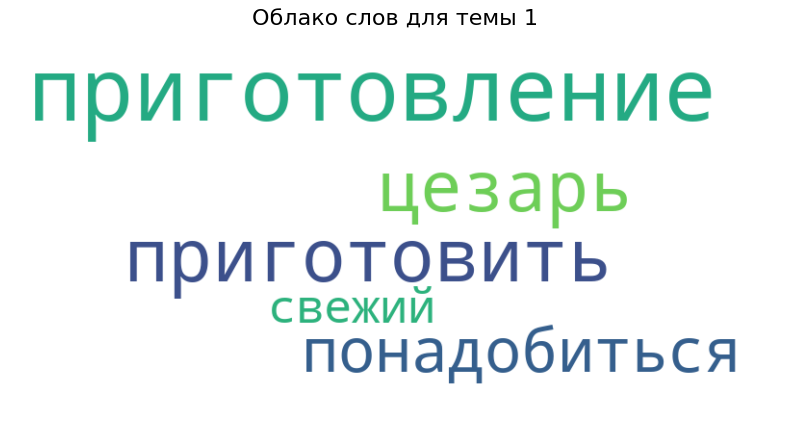

Документы для темы 1: doc2, doc17, doc11, doc1, doc9, doc7, doc6, doc8, doc5, doc3, doc4, doc18, doc20, doc13, doc19, doc12, doc14, doc15, doc16, doc10

Тема 2:
     Слово      Значение
0  выпечка  7.174940e-01
1     филе  6.515279e-01
2  желатин  2.413791e-01
3   гренка  4.949618e-02
4    салат  5.154275e-15


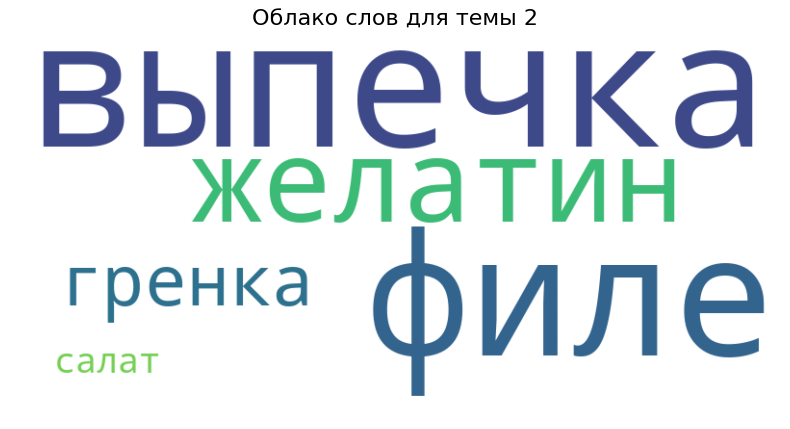

Документы для темы 2: doc15, doc10, doc14, doc16, doc18, doc12, doc11, doc19, doc13, doc20, doc9, doc17, doc7, doc8, doc6, doc5, doc4, doc3, doc1, doc2


In [39]:
documents = [f"doc{i + 1}" for i in range(len(filtered_text))]
analyze_topics(u, v_t, s, columns, documents)

### Вывод:

Проведен латентно-семантический анализ текстов с использованием сингулярного разложения терм-документной матрицы. Первые два сингулярных числа определяют основные темы, которые объясняют большую часть вариативности в данных. Для каждой темы выделены топ-5 значимых слов, характеризующих её содержание, и определены документы, наиболее связанные с этими темами. Облака слов для тем визуализируют их характер. Анализ показал, что темы структурируют данные, выявляя ключевые аспекты текстов, и позволяют понять содержательные связи между словами и документами.